###Imports

In [3]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import warnings
warnings.filterwarnings("ignore")

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk import sentiment
#from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


###Data Analysis

In [4]:
TMR_PATH = '/content/IMDb_TMR_Reviews.csv'

df = pd.read_csv(TMR_PATH, usecols = ['Reviews','Scores'])
df. rename(columns = {'Reviews':'review', 'Scores':'rating'}, inplace = True)
df.head()

,review,rating
0,"Warning Spoilers.First part of the movie, trie...",3.0
1,Some kind of fan-fiction? Did they write 5 scr...,NaN
2,If the SyFy channel made a Matrix series it wo...,2.0
3,I had been holding off from watching The Matri...,3.0
4,"The directors, writers and producers could hav...",1.0


In [5]:
print("Shape", df.shape)

Shape (5265, 2)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5265 entries, 0 to 5264
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   review  5265 non-null   object 
 1   rating  5199 non-null   float64
dtypes: float64(1), object(1)
memory usage: 82.4+ KB


In [7]:
df.isna().sum()
#there are 66 reviews which do not has associated ratings.

review     0
rating    66
dtype: int64

In [8]:
df = df[df['rating'].notna()]
print("Shape after filtering out NA ratings",df.shape)

Shape after filtering out NA ratings (5199, 2)


In [9]:
df['rating'] = df['rating'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5199 entries, 0 to 5264
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  5199 non-null   object
 1   rating  5199 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 121.9+ KB


In [10]:
ratings = df.rating.unique()
print("Rating values : ",np.sort(ratings))
print("Len ( Rating ) : ",len(ratings))

Rating values :  [ 1  2  3  4  5  6  7  8  9 10]
Len ( Rating ) :  10


In [11]:
print(df["rating"].value_counts())

1     1132
3      636
2      602
5      558
4      531
10     448
6      409
8      341
7      330
9      212
Name: rating, dtype: int64


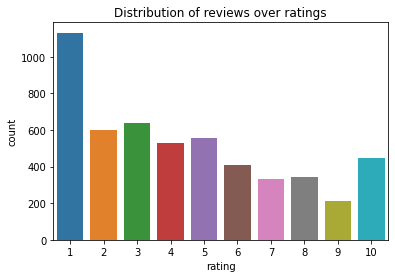

In [12]:
sns.countplot(df['rating'], data=df)
plt.title("Distribution of reviews over ratings")
plt.show()

* Every movie has a rating between 1-10.
* We have classified the ratings into 3 categories - Positive, Neutral, Negative.
* Positive = Rating [7,10]
* Neutral = Rating [5,6]
* Negative = Rating [1,4]
* We are focusing on Binary Classification of sentiments - Positive and Negative. Thus, we further filter out neutral rated reviews.


In [13]:
def generate_label(score):
    if score > 6 :
      return 'positive' #1
    elif score > 4 :
      return 'neutral' #0
    else : 
      return 'negative' #-1
    
#Assigning label to the dataset
df['label'] = df.apply(lambda x: generate_label(x['rating']), axis=1)
df.head(5)

,review,rating,label
0,"Warning Spoilers.First part of the movie, trie...",3,negative
2,If the SyFy channel made a Matrix series it wo...,2,negative
3,I had been holding off from watching The Matri...,3,negative
4,"The directors, writers and producers could hav...",1,negative
5,What even was this? This was so dumb. What wer...,1,negative


In [14]:
print(df["label"].value_counts())

negative    2901
positive    1331
neutral      967
Name: label, dtype: int64


In [15]:
#filter out neutral sentiments
df= df[df['label']!= 'neutral']

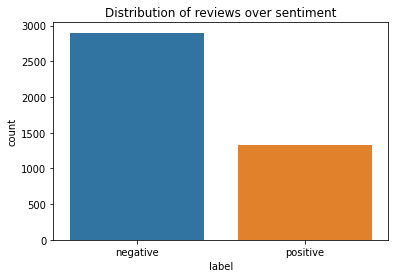

In [16]:
sns.countplot(df['label'], data=df)
plt.title("Distribution of reviews over sentiment")
plt.show()

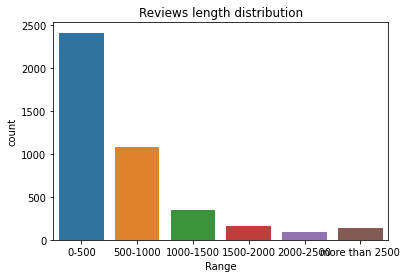

In [17]:
def calc_len(x):
  #print(len(x))
  return len(x)

df['wordcount'] = df['review'].apply(calc_len)
#df.head(5)

bins = [-1, 500, 1000, 1500, 2000, 2500, np.inf]
labels=['0-500','500-1000','1000-1500', '1500-2000', '2000-2500', 'more than 2500']
df['bins'] = pd.cut(df['wordcount'], bins=bins, labels=labels)

sns.countplot(df['bins'], data=df)
plt.title("Reviews length distribution")
plt.xlabel("Range")
plt.show()

In [18]:
df_wc=df.groupby(['bins','label']).size()
print (df_wc)

bins            label   
0-500           negative    1756
                positive     653
500-1000        negative     705
                positive     370
1000-1500       negative     215
                positive     136
1500-2000       negative      96
                positive      70
2000-2500       negative      59
                positive      33
more than 2500  negative      70
                positive      69
dtype: int64


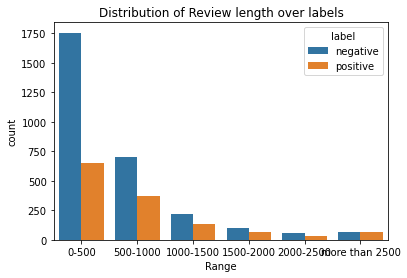

In [19]:
sns.countplot(x='bins', hue='label', data=df)
plt.title("Distribution of Review length over labels")
plt.xlabel("Range")
plt.show()

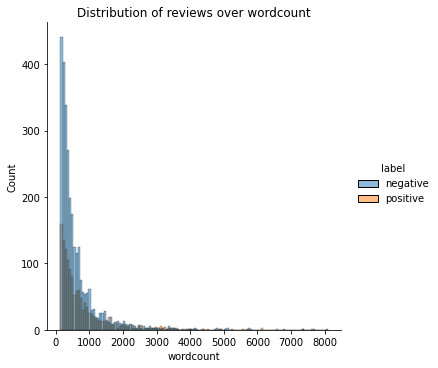

In [20]:
sns.displot(x= 'wordcount', hue = 'label', data = df)
plt.title('Distribution of reviews over wordcount')
plt.show()

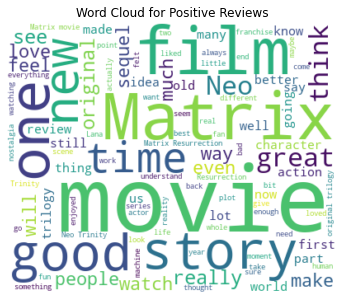

In [21]:
wcp = WordCloud(width=400, height=330, max_words=100, background_color='white').generate(" ".join(df[df.label == 'positive'].review))

plt.figure(figsize=(15,5))
plt.imshow(wcp, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Positive Reviews")
plt.show()

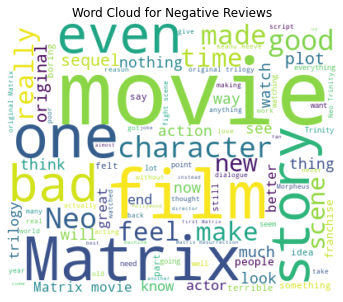

In [22]:
wcn = WordCloud(width=400, height=330, max_words=100, background_color='white').generate(" ".join(df[df.label == 'negative'].review))

plt.figure(figsize=(15,5))
plt.imshow(wcn, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Negative Reviews")
plt.show()

In [23]:
pos_wf = list(wcp.words_.keys())
neg_wf = list(wcn.words_.keys())
print("Positive Reviews : ",pos_wf)
print("Negative Reviews : ",neg_wf)
common = [x for x in pos_wf if x in neg_wf]
print("Common : ", common)

Positive Reviews :  ['movie', 'Matrix', 'film', 'one', 'story', 'good', 'new', 'time', 'great', 'think', 'Neo', 'really', 'original', 'see', 'people', 'way', 'will', 'much', 'make', 'watch', 'sequel', 'love', 'even', 'feel', 'character', 'thing', 'still', 'well', 'world', 'action', 'made', 'part', 'know', 'now', 'lot', 'trilogy', 'better', 'many', 'say', 'first', 'idea', 'us', 'going', 'old', 'review', 'Neo Trinity', 'end', 'understand', 'back', 'loved', 'want', 'Matrix Resurrection', 'franchise', 'year', 'something', 'bit', 'take', 'Matrix movie', 'thought', 'everything', 'real', 'bad', 'scene', 'fan', 'watching', 'Trinity', 'give', 'different', 'felt', 'original trilogy', 'plot', 'machine', 'point', 'little', 'series', 'actually', 'need', 'Resurrection', 'life', 'go', 'maybe', 'always', 'Lana', 'liked', 'work', 'human', 'look', 'sure', 'two', 'fun', 'actor', 'come', 'enough', 'nostalgia', 'reality', 'enjoyed', 'seem', 'best', 'whole', 'moment']
Negative Reviews :  ['movie', 'film', '

* Words like [ Film, Matrix, Movie, One, Story, Time, Neo, make, original, people, sequel, will ] are frequent in both the sentiments, thus they do not help in classification. 
* We will ignore these words during data cleaning.

### Data Cleaning

In [37]:
IGNORE_WORDS = ['Film', 'Matrix', 'Movie', 'One', 'Story', 'Time', 'Neo', 'make', 'original', 'people', 'sequel', 'will' ]

def clean_data(review):
    #print("Org : " , review)

    #HTML tag
    raw_text=BeautifulSoup(review, 'html').get_text()
    #print("Html : ",raw_text)

    #urls
    raw_text = re.sub(r"(www|http:|https:)+[\S]+[\w]", "", raw_text)
    #print("Links : ",raw_text)
    
    #non English character
    letters = re.sub('[^a-zA-Z]', ' ', raw_text)
    #print("Non English : ",letters)

    #lowercase
    tokens = letters.lower().split() 

    #filter ignore_words
    #tokens = [token for token in tokens if token not in IGNORE_WORDS] 
    #print(tokens)

    #stopwords and stemming
    stopwords = nltk.corpus.stopwords.words('english')
    wn = nltk.WordNetLemmatizer()
    words = [wn.lemmatize(w) for w in tokens if w not in stopwords ]
    
    #ignore_words
    IGNORE_WORDS_LEM = [wn.lemmatize(w).lower() for w in IGNORE_WORDS]
    words = [w for w in words if w not in IGNORE_WORDS_LEM]

    #ps = nltk.PorterStemmer()
    #words = [ps.stem(w) for w in tokens if w not in stopwords]
    
    #print("Tokens : ",words)
    return words

In [38]:
clean_data("film! this is test aaa <br> https://urls.com, is good with <b>technology</b>! Tests failed? Shawshank movies one two")

['test', 'aaa', 'good', 'technology', 'test', 'failed', 'shawshank', 'two']

In [39]:
df_X =  df['review'].apply(clean_data)
df_Y = df['label']
print(df_X.shape, df_Y.shape)

(4232,) (4232,)


In [40]:
def generate_vocab(data): 
  vocab = set()
  for clean_x in data : #cleaned_data
    for word in clean_x :
      #print(word)
      vocab.add(word)
      #break
  return sorted(vocab)

vocab = generate_vocab(df_X)
print("Vocab : ",vocab)
print("Length : ", len(vocab))

Vocab :  ['aaaaaaaaand', 'aaaaaalll', 'aaahhh', 'aard', 'ab', 'abandon', 'abandoned', 'abandonment', 'abdul', 'abhorrent', 'ability', 'abismal', 'able', 'abnormal', 'abode', 'abominable', 'abomination', 'abortion', 'abound', 'abounds', 'aboutfor', 'abrams', 'abrupt', 'abruptly', 'absence', 'absense', 'absent', 'absolute', 'absolutelly', 'absolutely', 'absolutly', 'absorb', 'absorbed', 'absorbent', 'abstinent', 'abstract', 'abstraction', 'absurb', 'absurd', 'absurdist', 'absurdistan', 'absurdity', 'absurdly', 'absurdness', 'abudent', 'abundance', 'abundantly', 'abuse', 'abused', 'abusing', 'abusive', 'abut', 'abyme', 'abysmal', 'abyss', 'academic', 'academically', 'academy', 'acc', 'acceleration', 'accent', 'accentuated', 'accept', 'acceptable', 'acceptance', 'accepted', 'accepting', 'access', 'accessibility', 'accessible', 'accident', 'accidentally', 'acclaimed', 'accolade', 'accommodate', 'accompanied', 'accompany', 'accompanying', 'accomplice', 'accomplish', 'accomplished', 'accompli

###Feature Extraction

####BagOfWords

In [42]:
from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer(analyzer = "word", tokenizer = lambda x: x, lowercase=False,  preprocessor = None, stop_words = None)
train_features = bow_vectorizer.fit_transform(df_X).toarray()
dfbow = pd.DataFrame(data=train_features,columns = bow_vectorizer.get_feature_names())
print(dfbow.shape)
dfbow.head()

(4232, 14800)


,aaaaaaaaand,aaaaaalll,aaahhh,aard,ab,abandon,abandoned,abandonment,abdul,abhorrent,...,zone,zoned,zoo,zoom,zoomed,zoomer,zucc,zucker,zuckerberg,zzzzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
features_count =  np.sum(train_features,axis=0)
features_count = pd.DataFrame(dict(features = bow_vectorizer.get_feature_names(), counts = features_count))
features_count.sort_values('counts', ascending=False)[0:20]

,features,counts
7380,like,3033
4892,first,1959
8505,new,1832
908,bad,1563
5504,good,1548
1904,character,1494
4348,even,1489
10233,really,1418
11295,scene,1395
13466,trilogy,1332


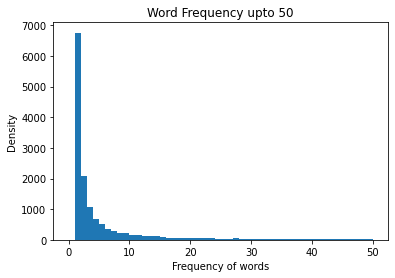

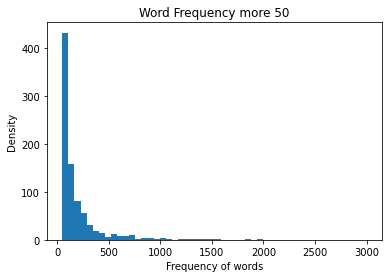

In [53]:
plt.title("Word Frequency upto 50")
plt.hist(features_count.counts, bins=50, range=(0,50))
plt.xlabel("Frequency of words")
plt.ylabel("Density")
plt.show()

plt.title("Word Frequency more 50")
plt.hist(features_count.counts, bins=50, range=(50,3000))
plt.xlabel("Frequency of words")
plt.ylabel("Density")
plt.show()

In [45]:
print("Features in bag of words : ",len(bow_vectorizer.vocabulary_))

Features in bag of words :  14800


####  TF-IDF

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False, use_idf=True) #stop_words='english' , smooth_idf=True(default)
tfidf = tfidf_vectorizer.fit_transform(df_X)

#print("Vocab : \n ",tfidf_vectorizer.vocabulary_) #mapping{word: feature index}
print("IDF Vector : \n ",tfidf_vectorizer.idf_)

IDF Vector : 
  [8.65751906 8.65751906 8.65751906 ... 8.25205395 7.55890677 8.65751906]


In [47]:
df_idf = pd.DataFrame(tfidf_vectorizer.idf_, index=tfidf_vectorizer.get_feature_names(),columns=["idf_weights"])
df_idf.sort_values(by=['idf_weights']).head(20)

,idf_weights
like,1.883867
first,2.180547
good,2.339452
new,2.365950
even,2.377123
bad,2.428022
character,2.468229
really,2.473370
trilogy,2.497367
made,2.503723


These are only IDF values. Inverse Document Frequency Score is inversely proportional to the usage frequency of the words. Not so important words which may not tell the context has lower IDF since they appear in every sentences.

In [48]:
idx = 5
print("\n Review tokens : ",df_X.loc[idx])
df_tfidf = pd.DataFrame(tfidf[idx].T.todense(), index=tfidf_vectorizer.get_feature_names_out (), columns=["tfidf"])
df_tfidf.sort_values(by=["tfidf"],ascending=False).head(20)


 Review tokens :  ['even', 'dumb', 'thinking', 'making', 'dialogue', 'corny', 'fight', 'scene', 'lame', 'asf', 'even', 'made']


,tfidf
resurrection,0.190873
fresh,0.177016
nightmare,0.162336
better,0.142846
game,0.140517
clip,0.119945
new,0.115641
called,0.115014
knew,0.114549
anderson,0.114092


Here, we see TFIDF values for 5th document of our trainset. We can explore other values by updating the value of idx.

In [49]:
print("Number of features : ",len(tfidf_vectorizer.vocabulary_))

Number of features :  14800
